In [12]:
import torch
import time
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import LineString
from train import model_factory
from models import GAT, GCN, GraphSAGE, GIN, MLP, NodeEdgeGNN
from data import InMemoryFloodEventDataset
from training import NodeRegressionTrainer, DualRegressionTrainer
from utils import file_utils
from extra.hydrographnet_flood_event_dataset import HydroGraphNetFloodEventDataset

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
np.random.seed(42)
torch.manual_seed(42)

## Print GAT Attention Weights

In [15]:
config_path = 'configs/config.yaml'
config = file_utils.read_yaml_file(config_path)

In [16]:
data_dir = "C:\\Users\\Carlo\\Documents\\School\\Masters\\NUS\\Dissertation\\HydroGraphNet\\outputs_phy\\data"
n_time_steps = 2
test_ids_file = "0_test.txt"
# use_physics_loss = False
use_physics_loss = True
rollout_length = 30

dataset = HydroGraphNetFloodEventDataset(data_dir=data_dir,
                                            prefix="M80",
                                            n_time_steps=n_time_steps,
                                            k=4,
                                            hydrograph_ids_file=test_ids_file,
                                            split="test",
                                            return_physics=use_physics_loss,
                                            rollout_length=rollout_length)

Processing Hydrographs: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


In [17]:
model_key = 'GAT'
# model_path = 'saved_models/hydrographnet/GAT_for_HydroGraphNet_2025-05-24_02-32-33_400events.pt'
model_path = 'saved_models/hydrographnet/GAT_for_HydroGraphNet_2025-05-24_06-56-23_physics.pt'
num_input_features = 16
num_edge_features = 3
num_output_features = 2 if use_physics_loss else 1

model_params = config['model_parameters'][model_key]

# Remove loss function parameters
model_params.pop('loss_func', None)
model_params.pop('loss_func_parameters', None)

if 'use_edge_features' in model_params and model_params['use_edge_features']:
    model_params['input_edge_features'] = num_edge_features
model_params['return_attn_weights'] = True # For analysis

model = model_factory(model_key,
                        input_features=num_input_features,
                        output_features=num_output_features,
                        **model_params)
model.load_state_dict(torch.load(model_path, weights_only=True))
# print(model)

<All keys matched successfully>

In [18]:
WATER_DEPTH_IDX = 12
VOLUME_IDX = WATER_DEPTH_IDX + n_time_steps
DATASET_IDX = 3

model.eval()
with torch.no_grad():
    global_idx = (DATASET_IDX-1) * rollout_length if DATASET_IDX is not None else 0
    limit = (DATASET_IDX * rollout_length) if DATASET_IDX is not None else len(dataset)
    while global_idx < limit:
        wd_sliding_window = dataset[global_idx].x.clone()[:, WATER_DEPTH_IDX:(WATER_DEPTH_IDX+n_time_steps)]
        # wd_sliding_window = wd_sliding_window.to(args.device)
        if use_physics_loss:
            v_sliding_window = dataset[global_idx].x.clone()[:, VOLUME_IDX:(VOLUME_IDX+n_time_steps)]
            # v_sliding_window = v_sliding_window.to(args.device)

        for idx in range(rollout_length):
            graph = dataset[global_idx]
            # graph = graph.to(args.device)
            graph.x[:, WATER_DEPTH_IDX:(WATER_DEPTH_IDX+n_time_steps)] = wd_sliding_window
            if use_physics_loss:
                graph.x[:, VOLUME_IDX:(VOLUME_IDX+n_time_steps)] = v_sliding_window

            pred = model(graph)

            if use_physics_loss:
                wd_sliding_window = torch.concat((wd_sliding_window[:, 1:], pred[:, 0:1]), dim=1)
                new_volume = v_sliding_window[:, 0:1] + pred[:, 1:2] # Predict volume change so we need to add it to the previous volume.
                v_sliding_window = torch.concat((v_sliding_window[:, -1:], new_volume), dim=1)
            else:
                wd_sliding_window = torch.concat((wd_sliding_window[:, 1:], pred), dim=1)

            global_idx += 1
        
        dyn_data_idx = (global_idx // rollout_length) - 1
        sample_id = dataset.dynamic_data[dyn_data_idx].get('hydro_id', idx)
        print(f"Hydrograph {sample_id}")

Hydrograph H403


In [19]:
def get_hydrographnet_gpd_node_df():
    xy_coords_path  = "C:\\Users\\Carlo\\Documents\\School\\Masters\\NUS\\Dissertation\\HydroGraphNet\\outputs_phy\\data\\M80_XY.txt"
    xy_coords = np.loadtxt(xy_coords_path, delimiter='\t')
    geometry = gpd.points_from_xy(xy_coords[:, 0], xy_coords[:, 1])
    node_df = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')
    return node_df

def convert_edge_index_to_gpd_df(edge_index: torch.Tensor, node_df: gpd.GeoDataFrame):
    edge_geometries = []
    edge_data = []

    for i in range(edge_index.shape[1]):
        source_idx = int(edge_index[0, i].item())
        source_geom = node_df.iloc[source_idx]['geometry']
        source_pos = (source_geom.x, source_geom.y)

        target_idx = int(edge_index[1, i].item())
        target_geom = node_df.iloc[target_idx]['geometry']
        target_pos = (target_geom.x, target_geom.y)
        
        line = LineString([source_pos, target_pos])
        edge_geometries.append(line)
        edge_data.append({
            'source': source_idx,
            'target': target_idx,
            'edge_id': i
        })

    edge_df = gpd.GeoDataFrame(edge_data, geometry=edge_geometries, crs='EPSG:4326')
    return edge_df

def plot_edge_map(edge_df: gpd.GeoDataFrame, value: np.ndarray=None, cmap=None, title=None):
    shared_plot_kwargs = {
        'linewidth': 0.5,
    }

    if value is not None:
        value_column = 'value'
        edge_df = edge_df.copy()
        edge_df[value_column] = value
        if cmap is None:
            cmap = plt.get_cmap('viridis') 
        shared_plot_kwargs.update({
            'cmap': cmap,
            'column': value_column,
            'legend': True,
            # 'legend_kwds': {
            #     'loc': 'upper right',
            #     'fontsize': 'x-small',
            # },
        })
        
    edge_df.plot(**shared_plot_kwargs)

    if title is not None:
        plt.title(title)

    plt.axis('off')

In [20]:
attn_weights = model.get_rollout_attn_weights()
list(attn_weights.keys())

['convs.module_0', 'convs.module_1']

Number of convolution steps:  30
Total number of edges:  23935
Retrieving top 1500 highest attention edges


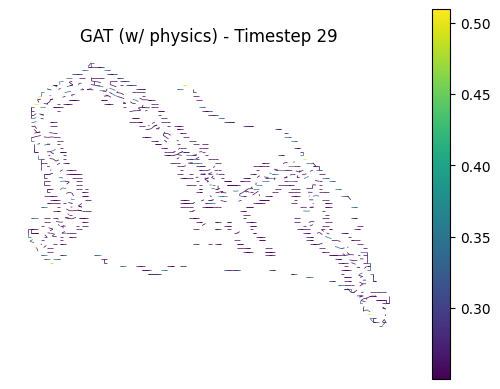

In [23]:
layer_key = 'convs.module_0'
timestep_idx = 29
topk = 1500

print('Number of convolution steps: ', len(attn_weights[layer_key]))

attn_edge_index, attn_weight = attn_weights[layer_key][timestep_idx]

print('Total number of edges: ', attn_edge_index.shape[1])

node_df = get_hydrographnet_gpd_node_df()
edge_df = convert_edge_index_to_gpd_df(attn_edge_index, node_df)

# Filter edges to be displayed based on attn_weight
print(f'Retrieving top {topk} highest attention edges')
values, indices = torch.sort(attn_weight.squeeze(), descending=True)
topk_indices = indices[:topk]
filtered_edge_df = edge_df.iloc[topk_indices]
filtered_attn_weight = attn_weight[topk_indices]

plot_edge_map(filtered_edge_df, filtered_attn_weight, title=f'GAT (w/ physics) - Timestep {timestep_idx}')

## Physics-informed

In [14]:
config_path = 'configs/config.yaml'
config = file_utils.read_yaml_file(config_path)

In [15]:
event_name = 'initp01'

dataset_parameters = config['dataset_parameters']
dataset_info_path = dataset_parameters['dataset_info_path']
event_parameters = dataset_parameters['flood_events'][event_name]

dataset = InMemoryFloodEventDataset(**event_parameters,
                            dataset_info_path=dataset_info_path,
                            previous_timesteps=dataset_parameters['previous_timesteps'],
                            node_features=dataset_parameters['node_features'],
                            edge_features=dataset_parameters['edge_features'],
                            normalize=dataset_parameters['normalize'],
                            # debug=True,
                            )
dataset_info = file_utils.read_yaml_file(dataset_info_path)

In [16]:
print(dataset[0].x)

tensor([[ 1.3979,  0.5419, -0.3490,  0.0000,  0.0000, -0.2856],
        [ 0.5913,  0.5419, -0.6528,  0.0000,  0.0000, -0.5389],
        [ 0.5364,  0.5419, -0.6823,  0.0000,  0.0000, -0.5849],
        ...,
        [-1.3095,  0.5419,  1.5454,  0.0000,  0.0000,  2.0618],
        [-1.3095,  0.5419,  0.8817,  0.0000,  0.0000,  0.4731],
        [-1.3095,  0.5419,  1.1568,  0.0000,  0.0000,  0.6879]])


In [54]:
# How to handle to node and from node? with velocity?
timestep = 100
edge_index = dataset[timestep].edge_index
edge_attr = dataset[timestep].edge_attr
mask = ((edge_index[0] == 186) & (edge_index[1] == 187)) | ((edge_index[1] == 186) & (edge_index[0] == 187))
indices = torch.nonzero(mask)
print(edge_index[:, 821], edge_attr[821, -1])
print(edge_index[:, 824], edge_attr[824, -1])

tensor([186, 187]) tensor(-0.0725)
tensor([187, 186]) tensor(-0.0725)


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
base_model_params = {
    'static_node_features': dataset_info['num_static_node_features'],
    'dynamic_node_features': dataset_info['num_dynamic_node_features'],
    'static_edge_features': dataset_info['num_static_edge_features'],
    'dynamic_edge_features': dataset_info['num_dynamic_edge_features'],
    'previous_timesteps': dataset_info['previous_timesteps'],
    'device': device,
}
lr_info = config['training_parameters']

## Node Prediction Models

In [8]:
node_model_map = {
    'SWEGNN': SWEGNN,
    'GCN': GCN,
    'GAT': GAT,
    'GIN': GIN,
    'GraphSAGE': GraphSAGE,
    'MLP': MLP,
}

In [9]:
model_name = 'GCN'
model_params = config['model_parameters'][model_name]
if model_name == 'MLP':
    model_params['num_nodes'] = len(train_dataset[0].x)
model = node_model_map[model_name](**model_params, **base_model_params)

num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = torch.nn.L1Loss()

trainer = NodeRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device)
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 37.1307
Epoch [2/10], Training Loss: 16.3665
Epoch [3/10], Training Loss: 14.5061
Epoch [4/10], Training Loss: 14.7616
Epoch [5/10], Training Loss: 13.5458
Epoch [6/10], Training Loss: 14.2750
Epoch [7/10], Training Loss: 12.4722
Epoch [8/10], Training Loss: 13.5450
Epoch [9/10], Training Loss: 13.2214
Epoch [10/10], Training Loss: 11.9427


Final training Loss: 11.9427
Average training Loss: 16.1767
Minimum training Loss: 11.9427
Maximum training Loss: 37.1307
Total training time: 36.6715 seconds
Validation Loss: 10.6697
Inference time: 0.0072 seconds


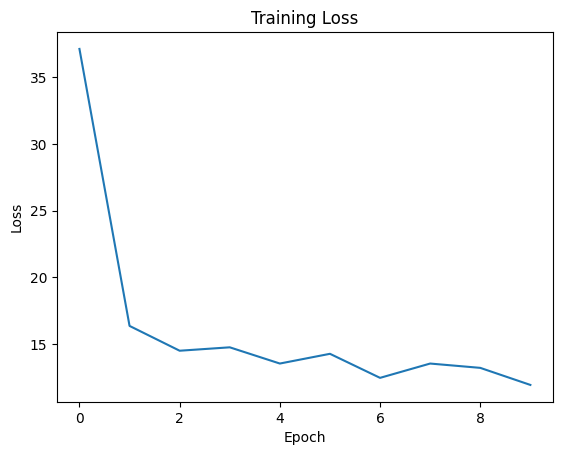

In [10]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

## Node and Edge Prediction

In [8]:
def node_edge_loss_func(node_pred, node_label, edge_pred, edge_label):
    loss_func = torch.nn.L1Loss()
    node_loss = loss_func(node_pred, node_label)
    edge_loss = loss_func(edge_pred, edge_label)
    return node_loss + edge_loss

In [9]:
model_params = config['model_parameters']['NodeEdgeGNN']
model = NodeEdgeGNN(**model_params, **base_model_params)

num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = node_edge_loss_func

trainer = DualRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device)
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 30.5009
Epoch [2/10], Training Loss: 0.7499
Epoch [3/10], Training Loss: 0.6726
Epoch [4/10], Training Loss: 0.6738
Epoch [5/10], Training Loss: 0.6738
Epoch [6/10], Training Loss: 50324.3104
Epoch [7/10], Training Loss: 18.5831
Epoch [8/10], Training Loss: 27.6478
Epoch [9/10], Training Loss: 18.8160
Epoch [10/10], Training Loss: 16.4935


Final training Loss: 16.4935
Average training Loss: 5043.9122
Minimum training Loss: 0.6726
Maximum training Loss: 50324.3104
Total training time: 55.5277 seconds
Validation Loss: 16.1494
Inference time: 0.0089 seconds


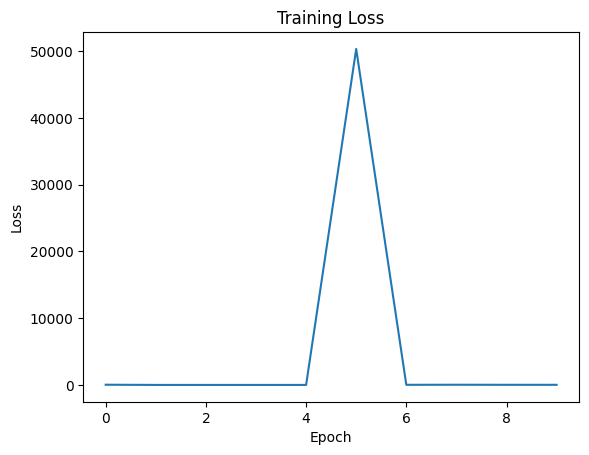

In [10]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

In [11]:
# Test with just Node Prediction
model = NodeEdgeGNN(**model_params, **base_model_params)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = torch.nn.L1Loss()
trainer = DualRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device,
                                mode='node')
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 32.9814
Epoch [2/10], Training Loss: 0.4615
Epoch [3/10], Training Loss: 0.4827
Epoch [4/10], Training Loss: 0.4691
Epoch [5/10], Training Loss: 0.5596
Epoch [6/10], Training Loss: 0.4685
Epoch [7/10], Training Loss: 0.5260
Epoch [8/10], Training Loss: 13865.3764
Epoch [9/10], Training Loss: 0.7634
Epoch [10/10], Training Loss: 0.7409


Final training Loss: 0.7409
Average training Loss: 1390.2829
Minimum training Loss: 0.4615
Maximum training Loss: 13865.3764
Total training time: 50.6878 seconds
Validation Loss: 0.2032
Inference time: 0.0068 seconds


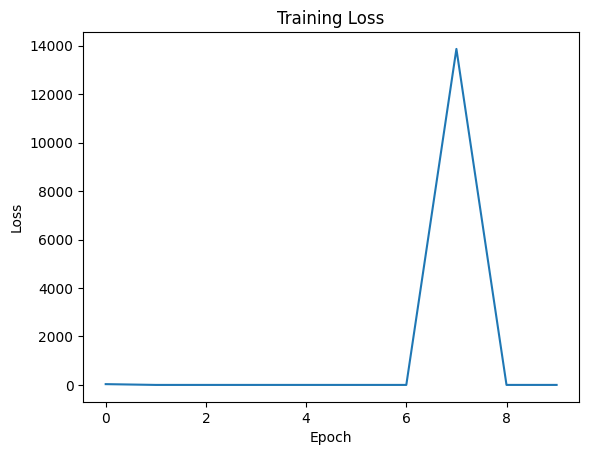

In [12]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

## Edge Prediction Models

In [ ]:
edge_model_map = {
    'EdgeGNN': EdgeGNN,
}

In [ ]:
model_name = 'EdgeGNN' # Choose from the ff: EdgeGNN
model_params = config['model_parameters'][model_name]
model = edge_model_map[model_name](**model_params, **base_model_params)

num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = torch.nn.L1Loss()

trainer = EdgeRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device)
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 15.5595
Epoch [2/10], Training Loss: 0.1695
Epoch [3/10], Training Loss: 0.1604
Epoch [4/10], Training Loss: 0.1544
Epoch [5/10], Training Loss: 0.1537
Epoch [6/10], Training Loss: 0.1539
Epoch [7/10], Training Loss: 0.1540
Epoch [8/10], Training Loss: 0.1587
Epoch [9/10], Training Loss: 0.2097
Epoch [10/10], Training Loss: 0.1854


Final training Loss: 0.1854
Average training Loss: 1.7059
Minimum training Loss: 0.1537
Maximum training Loss: 15.5595
Total training time: 9.7774 seconds
Validation Loss: 0.1083
Inference time: 0.0011 seconds


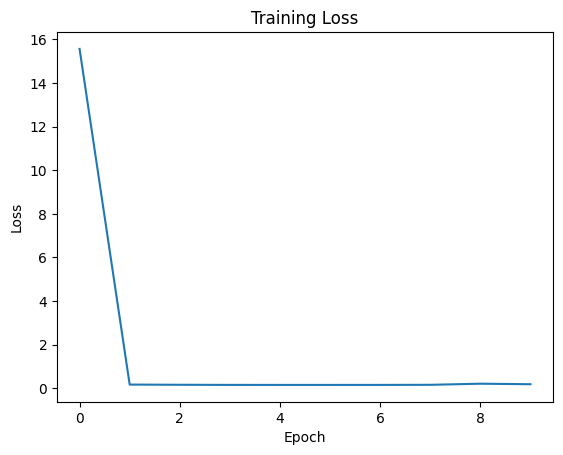

In [ ]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

## Self-Supervised Learning Methods

In [ ]:
from tqdm import tqdm
from models.graph_mae2 import GraphMAE2
from utils.graph_mae2_utils import LinearRegression

In [ ]:
dataset, info = FloodingEventDataset(node_features=config['node_features'],
                    edge_features=config['edge_features'],
                    **config['dataset_parameters']).load()

print(len(dataset))
print(dataset[0])
print(type(dataset[0].x), dataset[0].x.shape)
print(type(dataset[0].edge_index), dataset[0].edge_index.shape)
print(type(dataset[0].edge_attr), dataset[0].edge_attr.shape)
print(type(dataset[0].y), dataset[0].y.shape)
print(info)

336
Data(x=[1268, 6], edge_index=[2, 5224], edge_attr=[5224, 8], y=[1268, 1], pos=[2, 1268])
<class 'torch.Tensor'> torch.Size([1268, 6])
<class 'torch.Tensor'> torch.Size([2, 5224])
<class 'torch.Tensor'> torch.Size([5224, 8])
<class 'torch.Tensor'> torch.Size([1268, 1])
{'num_static_node_features': 3, 'num_dynamic_node_features': 1, 'num_static_edge_features': 5, 'num_dynamic_edge_features': 1, 'previous_timesteps': 2}


In [ ]:
num_train = int(len(dataset) * 0.8) # 80% train, 20% test

train_dataset = dataset[:num_train]
# train_loader = DataLoader(train_dataset) # batch_size=32, shuffle=True

test_dataset = dataset[num_train:]
# test_loader = DataLoader(test_dataset) # batch_size=32, shuffle=True

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
base_model_params = {
    'static_node_features': info['num_static_node_features'],
    'dynamic_node_features': info['num_dynamic_node_features'],
    'static_edge_features': info['num_static_edge_features'],
    'dynamic_edge_features': info['num_dynamic_edge_features'],
    'previous_timesteps': info['previous_timesteps'],
    'device': device,
}
lr_info = config['training_parameters']
model_info = config['model_parameters']

In [ ]:
def pretrain(model, dataset, optimizer):
    start_time = time.time()

    max_epoch = 20
    epoch_iter = tqdm(range(max_epoch))
    model.to(device)
    for epoch in epoch_iter:
        model.train()
        running_loss = 0.0

        for graph in dataset:
            graph = graph.to(device)
            x = graph.x # Target
            target_nodes = torch.arange(x.shape[0], device=device, dtype=torch.long)

            optimizer.zero_grad()

            loss = model(graph, x, targets=target_nodes)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / num_train
        epoch_iter.set_description(f"# Epoch {epoch}: train_loss: {epoch_loss:.4f}")

    end_time = time.time()
    print(f'Total pre-training time: {(end_time - start_time):4f} seconds')
    return model

def linear_probing(model, dataset, in_dim, out_dim, lr_f, weight_decay_f):
    start_time = time.time()

    decoder = LinearRegression(in_dim, out_dim).to(device)

    num_finetune_params = [p.numel() for p in decoder.parameters() if  p.requires_grad]
    print(f"num parameters for finetuning: {sum(num_finetune_params)}")

    loss_f = torch.nn.MSELoss()
    optimizer_f = torch.optim.Adam(decoder.parameters(), lr=lr_f, weight_decay=weight_decay_f)

    best_model = None
    max_epoch_f = 50
    epoch_iter_f = tqdm(range(max_epoch_f))
    model.eval()
    decoder.train()
    for epoch in epoch_iter_f:
        running_loss = 0.0

        for graph in dataset:
            optimizer_f.zero_grad()

            graph = graph.to(device)
            with torch.no_grad():
                x = model.embed(graph)
                x = x.to(device)
            label = graph.y

            out = decoder(x)
            loss = loss_f(out, label)

            loss.backward()
            optimizer_f.step()
            running_loss += loss.item()

        epoch_loss = running_loss / num_train
        epoch_iter_f.set_description(f"# Epoch {epoch}: train_loss: {epoch_loss:.4f}")

    end_time = time.time()
    print(f'Final loss: {epoch_loss:4f}')
    print(f'Total fine-tuning time: {(end_time - start_time):4f} seconds')

    return decoder

def test_ssl(model, ft_model, dataset, loss_func):
    start_time = time.time()
    model.eval()
    ft_model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for graph in dataset:
            graph = graph.to(device)
            x = model.embed(graph)
            labels = graph.y

            outputs = ft_model(x)

            loss = loss_func(outputs, labels)
            running_loss += loss.item()
    end_time = time.time()

    # Print validation statistics
    print(f'Validation Loss: {running_loss:.4f}')
    print(f'Inference time: {end_time - start_time} seconds')

In [ ]:
graphmae2_params = model_info['GRAPHMAE2']
in_dim = dataset[0].x.shape[1]
model = GraphMAE2(in_dim=in_dim, **graphmae2_params)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])

trained_model = pretrain(model, train_dataset, optimizer)

=== Use sce_loss and alpha_l=3 ===


# Epoch 19: train_loss: 0.0224: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]

Total pre-training time: 95.315137 seconds


In [ ]:
out_dim = dataset[0].y.shape[1]
hidden_dim = graphmae2_params['num_hidden'] // graphmae2_params['nhead']
ft_model = linear_probing(trained_model, train_dataset, hidden_dim, out_dim, 0.0008, lr_info['weight_decay'])

num parameters for finetuning: 2177


# Epoch 49: train_loss: 620.0525: 100%|██████████| 50/50 [00:56<00:00,  1.13s/it] 

Final loss: 620.052530
Total fine-tuning time: 56.627321 seconds


In [ ]:
loss_func = torch.nn.L1Loss()
test_ssl(trained_model, ft_model, test_dataset, loss_func)

Validation Loss: 32728.5642
Inference time: 0.2315971851348877 seconds


In [ ]:
from models.gine.pretrain_contextpred import main

model_file = 'models/gine/trained_model/gine_pretrain'
main(model_file)


cbow
num layer: 5 l1: 4 l2: 7
6
6
6
6
6
====epoch 1


Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([12894, 6])
torch.Size([12894, 1])


Iteration:   0%|          | 0/2 [00:20<?, ?it/s]


RuntimeError: running_mean should contain 1 elements not 6